# **Assignment 1 for Clustering**
---
## 💡 **Background**
<p>
New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.
</p><br>


---
## 📝 **Instructions**
<ol>
    <li> <b>Look at this website</b>: <u>https://rpubs.com/alanyang0924/TTE</u></li>
    <li> <b>Extract the dummy data</b> in the package and save it as "data_censored.csv"</li>
    <li> <b>Convert the R codes into Python Codes</b> (use Jupyter Notebook), replicate the results using your python code.</li>
    <li> <b>Create another copy of your Python Codes</b>, name it TTE-v2 (use Jupyter Notebook).</li>
    <li> Using TTE-v2, <b>think of a creative way on where you would integrate a clustering mechanism</b>, understand each step carefully and decide at which step a clustering method can be implemented.<b> Generate insights from your results</b>.</li>
    <li> Do this by pair, preferably your thesis partner.</li>
    <li> Push to your github repository.</li>
    <li> Deadline is 2 weeks from today:<b> February 28, 2025 at 11:59 pm</b>.</li>
</ol>
<br>

---

<style>
    ol > li::marker {
        font-weight: bold;
    }
</style>

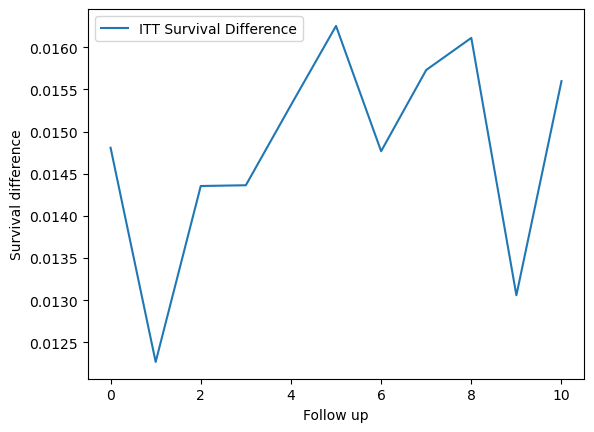

In [7]:
import pandas as pd
import numpy as np
from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
import tempfile

# Load data from CSV
data_censored = pd.read_csv("data_censored.csv")  

def calculate_weights(trial, is_itt=False):
    """Calculates combined weights."""
    if is_itt:
        trial['weight'] = trial['censor_weights']
    else:
        trial['weight'] = trial['switch_weights'] * trial['censor_weights']
    return trial

def fit_logistic_model(data, numerator_formula, denominator_formula, save_path):
    """Fits a logistic regression model."""
    numerator_model = Logit.from_formula(numerator_formula, data).fit(disp=0)
    denominator_model = Logit.from_formula(denominator_formula, data).fit(disp=0)

    return numerator_model, denominator_model

def calculate_switch_weights(trial, numerator_formula, denominator_formula, save_path):
    """Calculates switch weights."""
    numerator_model, denominator_model = fit_logistic_model(trial, numerator_formula, denominator_formula, save_path)
    numerator_probs = numerator_model.predict(trial)
    denominator_probs = denominator_model.predict(trial)
    trial['switch_weights'] = numerator_probs / denominator_probs
    return trial

def calculate_censor_weights(trial, censor_event, numerator_formula, denominator_formula, pool_models, save_path):
    """Calculates censor weights."""
    numerator_model, denominator_model = fit_logistic_model(trial, numerator_formula, denominator_formula, save_path)
    numerator_probs = numerator_model.predict(trial)
    denominator_probs = denominator_model.predict(trial)
    trial['censor_weights'] = numerator_probs / denominator_probs
    return trial

# Per-protocol
trial_pp = data_censored.copy()
trial_pp_dir = tempfile.mkdtemp()

trial_pp = calculate_switch_weights(trial_pp, 'treatment ~ age', 'treatment ~ age + x1 + x3', os.path.join(trial_pp_dir, "switch_models"))
trial_pp = calculate_censor_weights(trial_pp, 'outcome', 'outcome ~ x2', 'outcome ~ x2 + x1', 'none', os.path.join(trial_pp_dir, "switch_models")) #assuming outcome is the censoring event
trial_pp = calculate_weights(trial_pp)

# ITT
trial_itt = data_censored.copy()
trial_itt_dir = tempfile.mkdtemp()

trial_itt = calculate_censor_weights(trial_itt, 'outcome', 'outcome ~ x2', 'outcome ~ x2 + x1', 'numerator', os.path.join(trial_itt_dir, "switch_models")) #assuming outcome is the censoring event
trial_itt = calculate_weights(trial_itt, is_itt=True)

# Outcome model (simplified for demonstration)
def fit_outcome_model(data, outcome_formula):
    model = sm.OLS.from_formula(outcome_formula, data).fit()
    return model

outcome_model_pp = fit_outcome_model(trial_pp, 'outcome ~ treatment')
outcome_model_itt = fit_outcome_model(trial_itt, 'outcome ~ treatment + x2')

# Prediction (simplified)
def predict_survival_difference(model, data, predict_times):
    results = []
    for time in predict_times:
        newdata = data[data['period'] == time]
        if not newdata.empty:
            predictions = model.predict(newdata)
            results.append({'followup_time': time, 'survival_diff': predictions.mean()})
    return pd.DataFrame(results)

predict_times = range(0, 11)
preds_itt = predict_survival_difference(outcome_model_itt, trial_itt, predict_times)

# Plotting
plt.plot(preds_itt['followup_time'], preds_itt['survival_diff'], label='ITT Survival Difference')
plt.xlabel('Follow up')
plt.ylabel('Survival difference')
plt.legend()
plt.show()